In [4]:
from operator import add
from typing import List, TypedDict, Optional, Annotated, Dict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END


# The structure of the logs
class Logs(TypedDict):
    id: str
    question: str
    docs: Optional[List]
    answer: str
    grade: Optional[int]
    grader: Optional[str]
    feedback: Optional[str]


# Failure Analysis Sub-graph
class FailureAnalysisState():
    docs: List[Logs]
    failures: List[Logs]
    fa_summary: str


def get_failures(state):
    docs = state["docs"]
    failures = [doc for doc in docs if "grade" in doc]
    return {"failures": failures}


def generate_summary(state):
    failures = state["failures"]
    # Add fxn: fa_summary = summarize(failures)
    fa_summary = "Poor quality retrieval of Chroma documentation."
    return {"fa_summary": fa_summary}


fa_builder = StateGraph(FailureAnalysisState)
fa_builder.add_node("get_failures", get_failures)
fa_builder.add_node("generate_summary", generate_summary)
fa_builder.add_edge(START, "get_failures")
fa_builder.add_edge("get_failures", "generate_summary")
fa_builder.add_edge("generate_summary", END)


# Summarization subgraph
class QuestionSummarizationState():
    docs: List[Logs]
    qs_summary: str
    report: str


def generate_summary(state):
    docs = state["docs"]
    # Add fxn: summary = summarize(docs)
    summary = "Questions focused on usage of ChatOllama and Chroma vector store."
    return {"qs_summary": summary}


def send_to_slack(state):
    qs_summary = state["qs_summary"]
    # Add fxn: report = report_generation(qs_summary)
    report = "foo bar baz"
    return {"report": report}


def format_report_for_slack(state):
    report = state["report"]
    # Add fxn: formatted_report = report_format(report)
    formatted_report = "foo bar"
    return {"report": formatted_report}


qs_builder = StateGraph(QuestionSummarizationState)
qs_builder.add_node("generate_summary", generate_summary)
qs_builder.add_node("send_to_slack", send_to_slack)
qs_builder.add_node("format_report_for_slack", format_report_for_slack)
qs_builder.add_edge(START, "generate_summary")
qs_builder.add_edge("generate_summary", "send_to_slack")
qs_builder.add_edge("send_to_slack", "format_report_for_slack")
qs_builder.add_edge("format_report_for_slack", END)

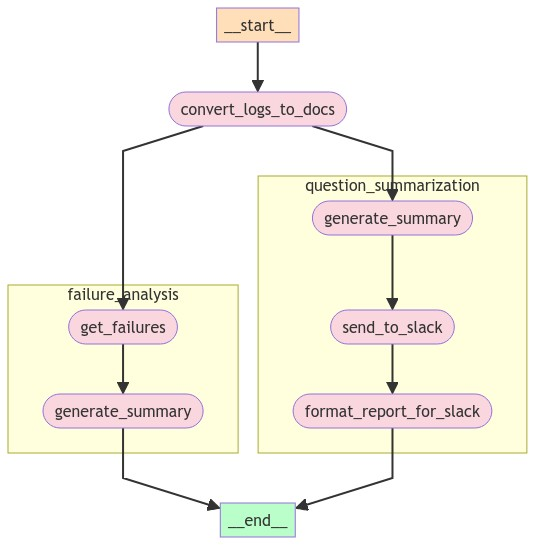

In [5]:
# Dummy logs
question_answer = Logs(
    id="1",
    question="How can I import ChatOllama?",
    answer="To import ChatOllama, use: 'from langchain_community.chat_models import ChatOllama.'",
)

question_answer_feedback = Logs(
    id="2",
    question="How can I use Chroma vector store?",
    answer="To use Chroma, define: rag_chain = create_retrieval_chain(retriever, question_answer_chain).",
    grade=0,
    grader="Document Relevance Recall",
    feedback="The retrieved documents discuss vector stores in general, but not Chroma specifically",
)


# Entry Graph
class EntryGraphState():
    raw_logs: Annotated[List[Dict], add]
    docs: Annotated[List[Logs], add]  # This will be used in sub-graphs
    fa_summary: str  # This will be generated in the FA sub-graph
    report: str  # This will be generated in the QS sub-graph


def convert_logs_to_docs(state):
    # Get logs
    raw_logs = state["raw_logs"]
    docs = [question_answer, question_answer_feedback]
    return {"docs": docs}


entry_builder = StateGraph(EntryGraphState)
entry_builder.add_node("convert_logs_to_docs", convert_logs_to_docs)
entry_builder.add_node("question_summarization", qs_builder.compile())
entry_builder.add_node("failure_analysis", fa_builder.compile())

entry_builder.add_edge(START, "convert_logs_to_docs")
entry_builder.add_edge("convert_logs_to_docs", "failure_analysis")
entry_builder.add_edge("convert_logs_to_docs", "question_summarization")
entry_builder.add_edge("failure_analysis", END)
entry_builder.add_edge("question_summarization", END)

graph = entry_builder.compile()

from IPython.display import Image, display

# Setting xray to 1 will show the internal structure of the nested graph
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [6]:
raw_logs = [{"foo": "bar"}, {"foo": "baz"}]
graph.invoke({"raw_logs": raw_logs}, debug=False)

TypeError: EntryGraphState() takes no arguments